**Instituto Tecnológico de Estudios Superiores de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

**Proyecto Integrador**

**Nombre del trabajo** EDA

**Nombre del maestro:** 

    Dra. Grettel Barceló Alonso
    Dr. Luis Eduardo Falcón Morales

**Nombre de los estudiantes:** 
                
                Kevin Brandon Cruz Mejia
                José Alberto Almada Gerardo

**Matrículas:**
             A01794176
     		 A01794415

**Fecha de entrega:** 9 de septiembre de 2024

Como se menciono en el anterior entragable para hacer mas entendible el negocio para realizar el banco de casos de uso
se hara por fases en esta fase 1 tenemos el caso de uso de "Confirmación de registros contables" para el sector de Contabilidad, finanzas e Impuestos de Mexico con el proposito de realizar los entregables en tiempo y forma de este curso/proyecto ademas de seguir actualizando el github https://github.com/KevinBCruzMejia/ProyectoIntegrador/tree/main con demas casos de uso replicando este mismo analisis al menos en esta este paso de preprocesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
import warnings

In [2]:
# Cargar el conjunto de datos
data = pd.read_csv("Data\ejercicio_del_gasto.csv", index_col=0,  encoding='latin-1')

In [3]:
df = data.copy() #Definimos un DataFrame para usar como BD

In [4]:
# Anteriormente identificamos que en el documento tiene comas por ello las eliminamos asi como guiones
df = df.replace(',', '', regex=True)
df = df.replace('-', '', regex=True)

In [5]:
def valores_faltantes(df):
    print("¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? ")
    tiene_nan = df.isnull().values.any()
    missing_data = df.isnull().sum()
    print(missing_data[missing_data > 0])
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Mapa de calor de valores faltantes")
    plt.show()
    if tiene_nan:
        print("El DataFrame contiene valores NaN o null.")
    else:
        print("El DataFrame no tiene valores NaN o null.")

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? 
PROGRAMA_FONDO_CONVENIO_ESPECIFICO    11550
  MONTO_APROBADO                      30520
  MONTO_MODIFICADO                    13403
  MONTO_RECAUDADO                     13998
  MONTO_COMPROMETIDO                  14507
  MONTO_DEVENGADO                     14631
  MONTO_EJERCIDO                      14767
  MONTO_PAGADO                        14846
OBSERVACIONES_CAPTURISTA              79566
dtype: int64


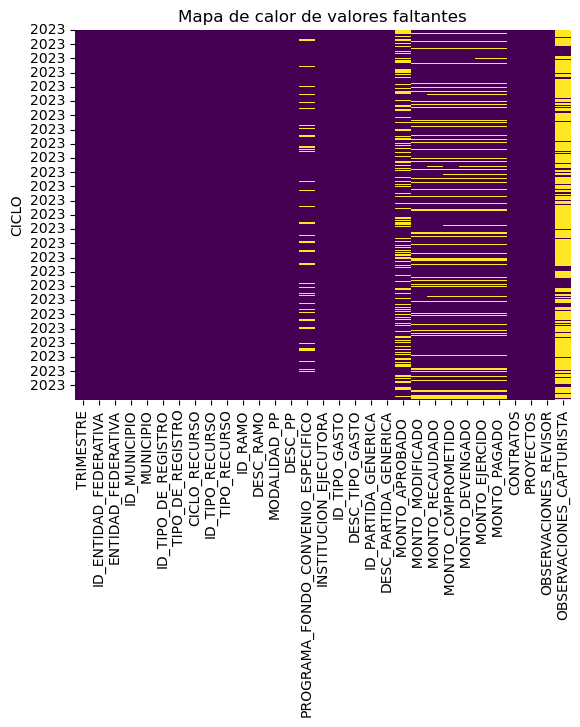

El DataFrame contiene valores NaN o null.


In [6]:
valores_faltantes(df)

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? 
    
    Si hay valores faltantes principalmente en dos columnas y con la grafica se puede identificar patrones de ausencia

In [7]:
# Eliminar las columnas 'PROGRAMA_FONDO_CONVENIO_ESPECIFICO' y 'OBSERVACIONES_CAPTURISTA'
df = df.drop(['PROGRAMA_FONDO_CONVENIO_ESPECIFICO', 'OBSERVACIONES_CAPTURISTA'], axis=1)

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? 
  MONTO_APROBADO          30520
  MONTO_MODIFICADO        13403
  MONTO_RECAUDADO         13998
  MONTO_COMPROMETIDO      14507
  MONTO_DEVENGADO         14631
  MONTO_EJERCIDO          14767
  MONTO_PAGADO            14846
dtype: int64


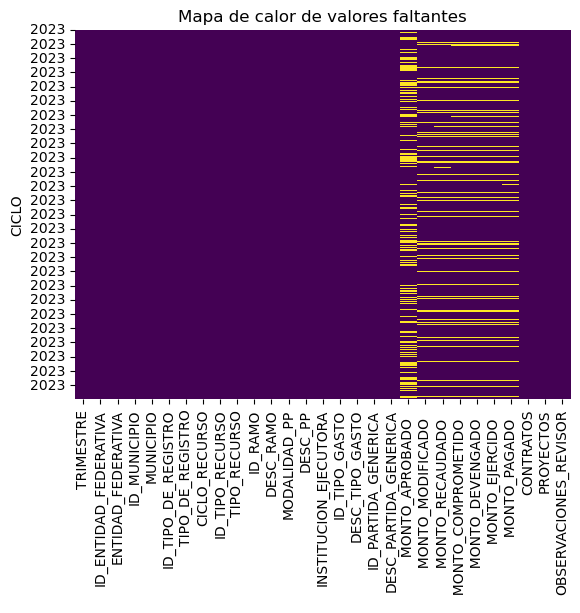

El DataFrame contiene valores NaN o null.


In [8]:
valores_faltantes(df)

In [9]:
# Despues de eliminar dos columnas vemos que exist un patron en otras que son utiles por lo que
# Rellenar los NaN con un valor, por ejemplo 0
df_rellenado = df.fillna(0)

print(df_rellenado)

       TRIMESTRE  ID_ENTIDAD_FEDERATIVA ENTIDAD_FEDERATIVA  ID_MUNICIPIO  \
CICLO                                                                      
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
...          ...                    ...                ...           ...   
2023           5                     32          Zacatecas            56   
2023           5                     32          Zacatecas            56   
2023           5                     32          Zacatecas            56   
2023           5                     32          Zacatecas            56   
2023           5                     32          Zacatecas            56   

           

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? 
Series([], dtype: int64)


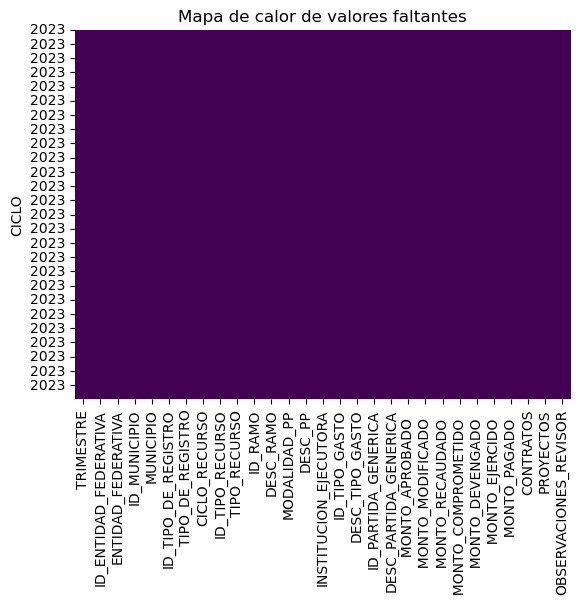

El DataFrame no tiene valores NaN o null.


In [10]:
valores_faltantes(df_rellenado)

In [11]:
df_rellenado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98606 entries, 2023 to 2023
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TRIMESTRE               98606 non-null  int64 
 1   ID_ENTIDAD_FEDERATIVA   98606 non-null  int64 
 2   ENTIDAD_FEDERATIVA      98606 non-null  object
 3   ID_MUNICIPIO            98606 non-null  int64 
 4   MUNICIPIO               98606 non-null  object
 5   ID_TIPO_DE_REGISTRO     98606 non-null  int64 
 6   TIPO_DE_REGISTRO        98606 non-null  object
 7   CICLO_RECURSO           98606 non-null  int64 
 8   ID_TIPO_RECURSO         98606 non-null  int64 
 9   TIPO_RECURSO            98606 non-null  object
 10  ID_RAMO                 98606 non-null  int64 
 11  DESC_RAMO               98606 non-null  object
 12  MODALIDAD_PP            98606 non-null  object
 13  DESC_PP                 98606 non-null  object
 14  INSTITUCION_EJECUTORA   98606 non-null  object
 15  

Como podemos visualizar ya no hay valores null o NaN pero ahora debemos convertir el data type a entero en caso de que aplique para poder realizar los siguientes analisis

In [12]:
# Identificar las columnas de tipo object
columnas_object = df_rellenado.select_dtypes(include=['object']).columns

# Crear una lista para guardar las columnas que se pueden convertir a tipo decimal (float)
columnas_convertibles = []

# Intentar convertir las columnas a float
for col in columnas_object:
    try:
        # Intentar convertir la columna a float
        df_rellenado[col] = pd.to_numeric(df_rellenado[col], errors='raise')  # Convierte a float

        # Si la conversión es exitosa, agregar la columna a la lista
        columnas_convertibles.append(col)
    except (ValueError, TypeError):
        # Si ocurre un error de conversión, continuar con la siguiente columna
        pass

# Mostrar las columnas que se pueden convertir a tipo decimal
print("Columnas convertidas a un tipo decimal (float):", columnas_convertibles)

# Mostrar el DataFrame actualizado
print("\nDataFrame actualizado:")
print(df_rellenado)

Columnas convertidas a un tipo decimal (float): ['  MONTO_APROBADO  ', '  MONTO_MODIFICADO  ', '  MONTO_RECAUDADO  ', '  MONTO_COMPROMETIDO  ', '  MONTO_DEVENGADO  ', '  MONTO_EJERCIDO  ', '  MONTO_PAGADO  ']

DataFrame actualizado:
       TRIMESTRE  ID_ENTIDAD_FEDERATIVA ENTIDAD_FEDERATIVA  ID_MUNICIPIO  \
CICLO                                                                      
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
2023           5                      1     Aguascalientes             1   
...          ...                    ...                ...           ...   
2023           5                     32          Zacatecas            56   
2023           5                     32          Zacatecas            56   
2023   

In [13]:
df_rellenado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98606 entries, 2023 to 2023
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TRIMESTRE               98606 non-null  int64  
 1   ID_ENTIDAD_FEDERATIVA   98606 non-null  int64  
 2   ENTIDAD_FEDERATIVA      98606 non-null  object 
 3   ID_MUNICIPIO            98606 non-null  int64  
 4   MUNICIPIO               98606 non-null  object 
 5   ID_TIPO_DE_REGISTRO     98606 non-null  int64  
 6   TIPO_DE_REGISTRO        98606 non-null  object 
 7   CICLO_RECURSO           98606 non-null  int64  
 8   ID_TIPO_RECURSO         98606 non-null  int64  
 9   TIPO_RECURSO            98606 non-null  object 
 10  ID_RAMO                 98606 non-null  int64  
 11  DESC_RAMO               98606 non-null  object 
 12  MODALIDAD_PP            98606 non-null  object 
 13  DESC_PP                 98606 non-null  object 
 14  INSTITUCION_EJECUTORA   98606 non-nu

Como podemos apreciar ahora tenemos el DF con el tipo de dato adecuado y sin NaN o Null

In [14]:
def estadisticas_resumidas(df):
    print("¿Cuáles son las estadísticas resumidas del conjunto de datos?")
    print(df.describe())

In [15]:
estadisticas_resumidas(df_rellenado)

¿Cuáles son las estadísticas resumidas del conjunto de datos?
       TRIMESTRE  ID_ENTIDAD_FEDERATIVA  ID_MUNICIPIO  ID_TIPO_DE_REGISTRO  \
count    98606.0           98606.000000  98606.000000              98606.0   
mean         5.0              17.679279     47.552218                  2.0   
std          0.0               8.295929     99.382348                  0.0   
min          5.0               1.000000      0.000000                  2.0   
25%          5.0              11.000000      0.000000                  2.0   
50%          5.0              18.000000      4.000000                  2.0   
75%          5.0              24.000000     47.000000                  2.0   
max          5.0              32.000000    570.000000                  2.0   

       CICLO_RECURSO  ID_TIPO_RECURSO       ID_RAMO  ID_TIPO_GASTO  \
count   98606.000000     98606.000000  98606.000000   98606.000000   
mean     2022.955733         2.003549     25.669077       1.196479   
std         0.475427     

In [16]:
def detectar_valores_atipicos(df):
    print("¿Hay valores atípicos en el conjunto de datos?")
    for col in df.select_dtypes(include=[np.number]).columns:
        sns.boxplot(x=df[col])
        plt.title(f'Detección de valores atípicos para {col}')
        plt.show()

¿Hay valores atípicos en el conjunto de datos?


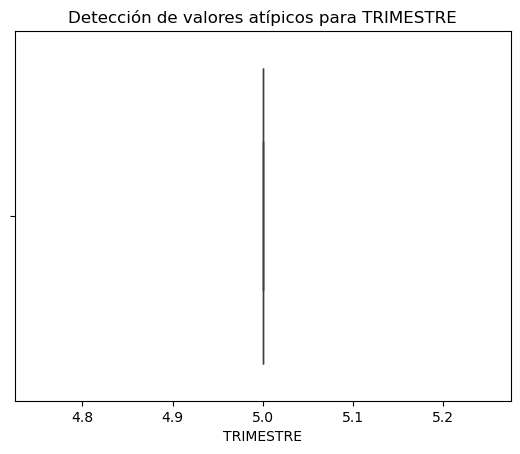

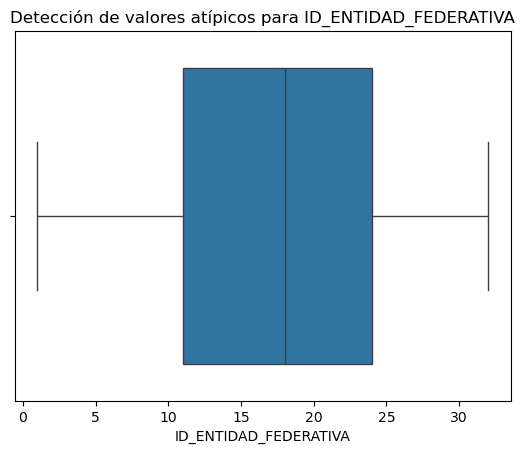

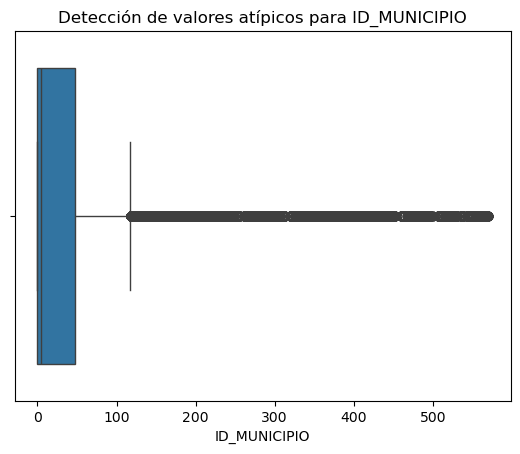

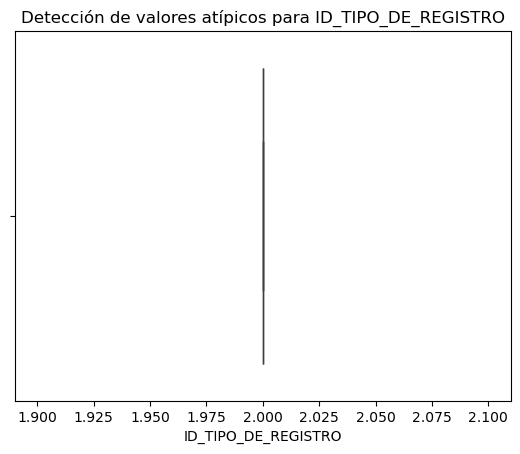

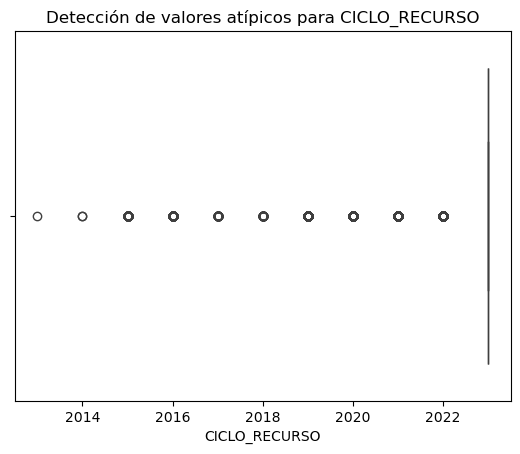

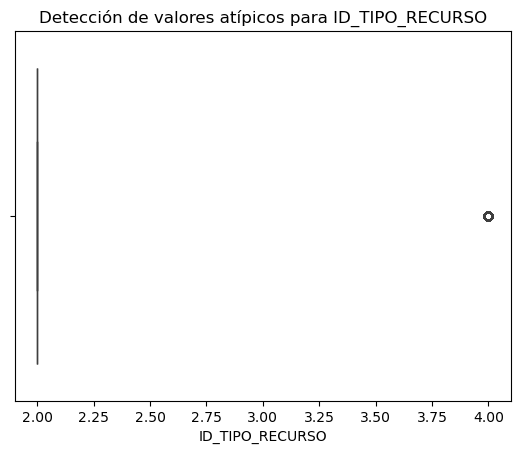

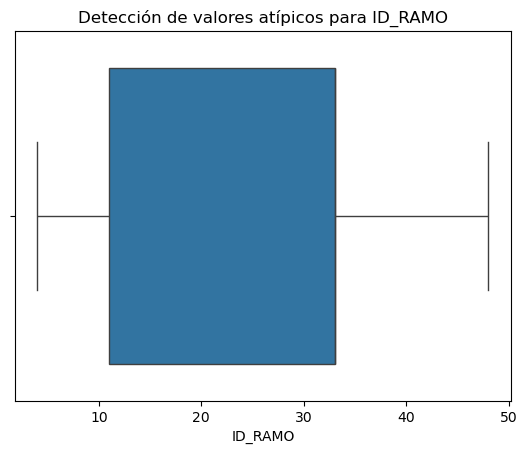

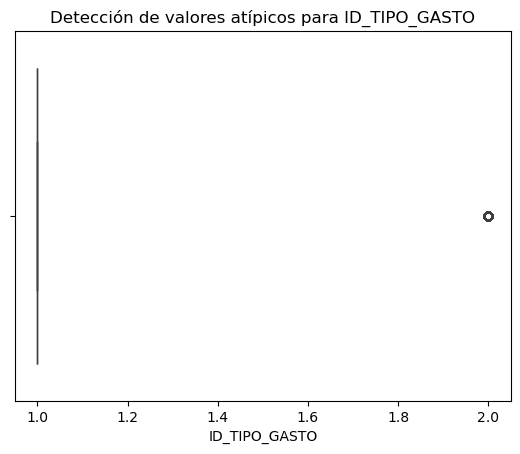

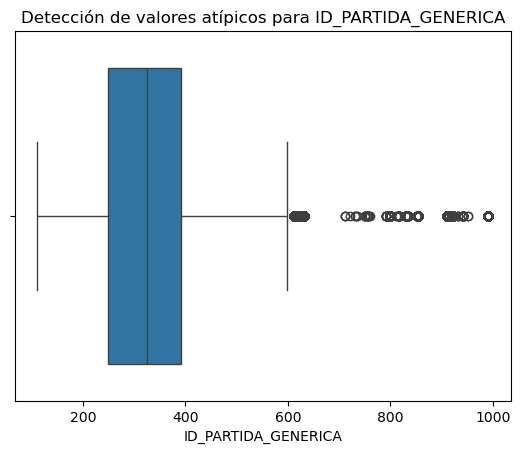

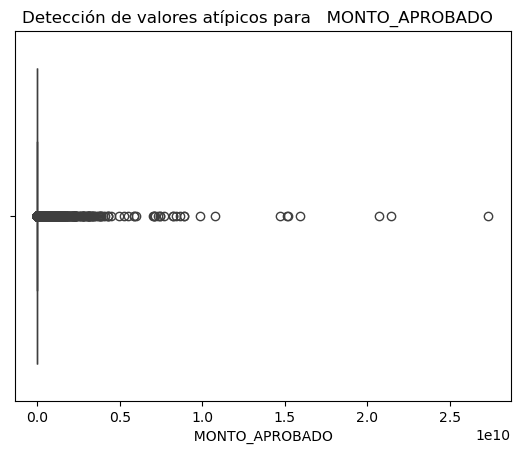

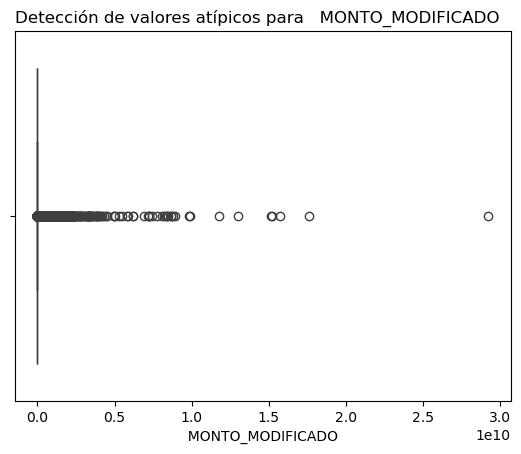

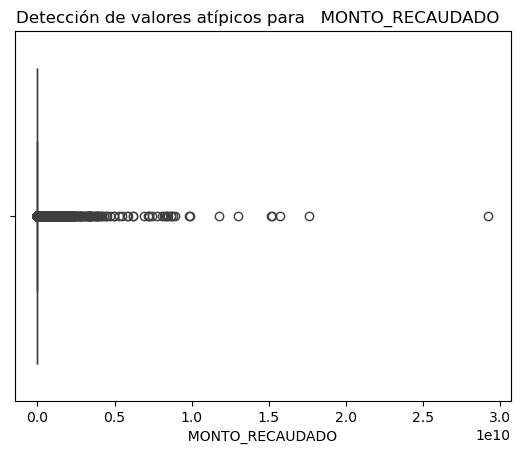

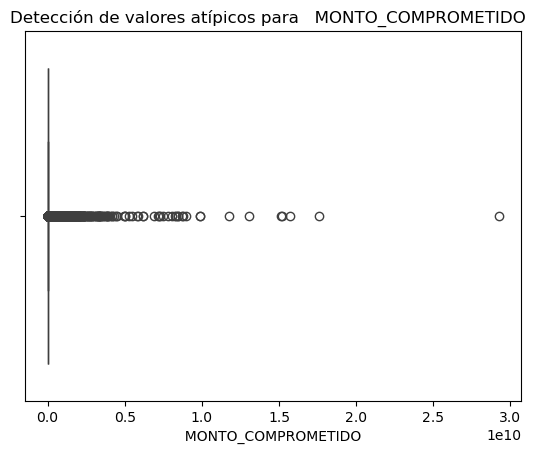

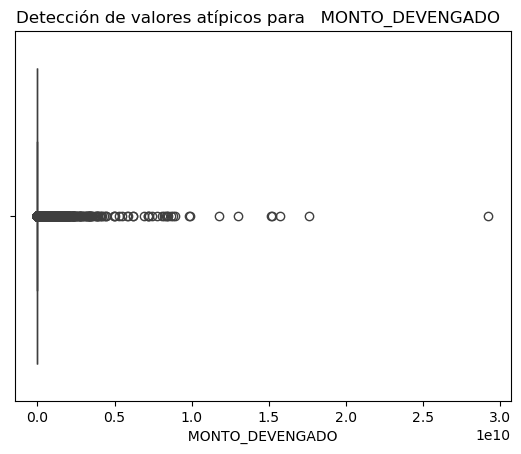

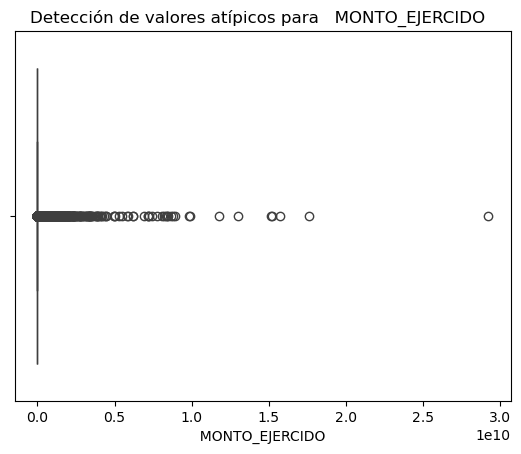

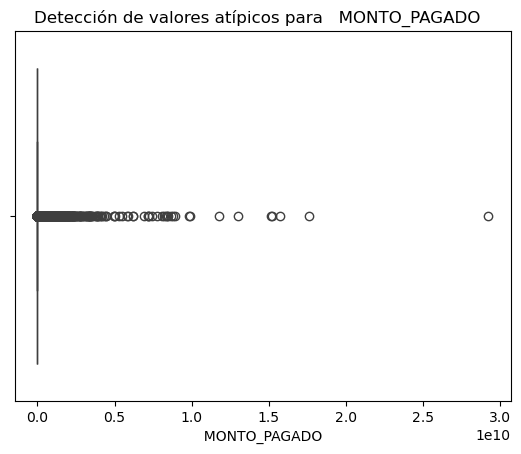

In [17]:
detectar_valores_atipicos(df_rellenado)

Los valores atipicos identificados son
ID_PARTIDA_GENERICA
MONTO_APROBADO
MONTO_MODIFICADO
MONTO_RECAUDADO
MONTO_COMPROMETIDO
MONTO_DEVENGADO
MONTO_EJERCIDO
MONTO_PAGADO

In [18]:
def cardinalidad_variables_categoricas(df):
    print("¿Cuál es la cardinalidad de las variables categóricas?")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f'{col}: {df[col].nunique()} categorías únicas')

In [19]:
cardinalidad_variables_categoricas(df_rellenado)

¿Cuál es la cardinalidad de las variables categóricas?
ENTIDAD_FEDERATIVA: 32 categorías únicas
MUNICIPIO: 1783 categorías únicas
TIPO_DE_REGISTRO: 1 categorías únicas
TIPO_RECURSO: 2 categorías únicas
DESC_RAMO: 18 categorías únicas
MODALIDAD_PP: 104 categorías únicas
DESC_PP: 115 categorías únicas
INSTITUCION_EJECUTORA: 2765 categorías únicas
DESC_TIPO_GASTO: 2 categorías únicas
DESC_PARTIDA_GENERICA: 286 categorías únicas
CONTRATOS: 68 categorías únicas
PROYECTOS: 139 categorías únicas
OBSERVACIONES_REVISOR: 111 categorías únicas


Fórmula de Normalización

La normalización de un valor x se puede calcular usando la siguiente fórmula:

normalized = (2 * (x - min)) / (max - min) - 1

Donde:
- x es el valor a normalizar.
- min es el valor mínimo de la columna.
- max es el valor máximo de la columna.

Proceso de Normalización
1. Encontrar el valor mínimo y máximo de la columna.
2. Aplicar la fórmula a cada valor en la columna para escalarlo al rango de -1 a 1.


In [20]:
# Normalizar cada columna del DataFrame
def normalizar_columna(col):
    min_val = col.min()
    max_val = col.max()
    return 2 * (col - min_val) / (max_val - min_val) - 1

In [21]:
# Aplicar la normalización a cada columna numérica
df_normalizado = df_rellenado.apply(lambda col: normalizar_columna(col) if col.dtype in ['int64', 'float64'] else col)
# Eliminar columnas que contienen NaN
df_normalizado = df_normalizado.dropna(axis=1)
# Mostrar el DataFrame normalizado
print("DataFrame normalizado:")
print(df_normalizado)

DataFrame normalizado:
       ID_ENTIDAD_FEDERATIVA ENTIDAD_FEDERATIVA  ID_MUNICIPIO       MUNICIPIO  \
CICLO                                                                           
2023                    -1.0     Aguascalientes     -0.996491  Aguascalientes   
2023                    -1.0     Aguascalientes     -0.996491  Aguascalientes   
2023                    -1.0     Aguascalientes     -0.996491  Aguascalientes   
2023                    -1.0     Aguascalientes     -0.996491  Aguascalientes   
2023                    -1.0     Aguascalientes     -0.996491  Aguascalientes   
...                      ...                ...           ...             ...   
2023                     1.0          Zacatecas     -0.803509       Zacatecas   
2023                     1.0          Zacatecas     -0.803509       Zacatecas   
2023                     1.0          Zacatecas     -0.803509       Zacatecas   
2023                     1.0          Zacatecas     -0.803509       Zacatecas   
2023 

In [22]:
# Ignorar RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def distribuciones_sesgadas(df):
    print("¿Existen distribuciones sesgadas en el conjunto de datos?")

    # Seleccionar solo columnas con tipos de datos Int64 o Float64
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Definir número de columnas para subplots
    num_cols = 3  # Columnas
    num_rows = int(np.ceil(len(numeric_cols) / num_cols))

    # Crear figura y ejes para subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

    for i, col in enumerate(numeric_cols):
        # Eliminar NaN antes de graficar
        valid_data = df[col].dropna()
        sns.histplot(valid_data, kde=True, bins=30, ax=axes[i])  # Ajustar el número de bins
        axes[i].set_title(f'Distribución de {col}')

    # Eliminar ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    print("¿Necesitamos aplicar alguna transformación no lineal?")

    for col in numeric_cols:
        # Aplicar PowerTransformer solo si hay suficientes datos válidos
        valid_data = df[col].dropna()
        if valid_data.shape[0] > 0:  # Verificar que hay datos disponibles
            pt = PowerTransformer()
            transformed_data = pt.fit_transform(valid_data.values.reshape(-1, 1))  # Ajustar la forma de los datos
            
            # Gráficar la transformación no lineal
            sns.histplot(transformed_data, kde=True, bins=30)  # Ajustar el número de bins
            plt.title(f'Transformación no lineal para {col}')
            plt.show()
            plt.pause(0.1)  # Pausa breve para mejorar el rendimiento



¿Existen distribuciones sesgadas en el conjunto de datos?


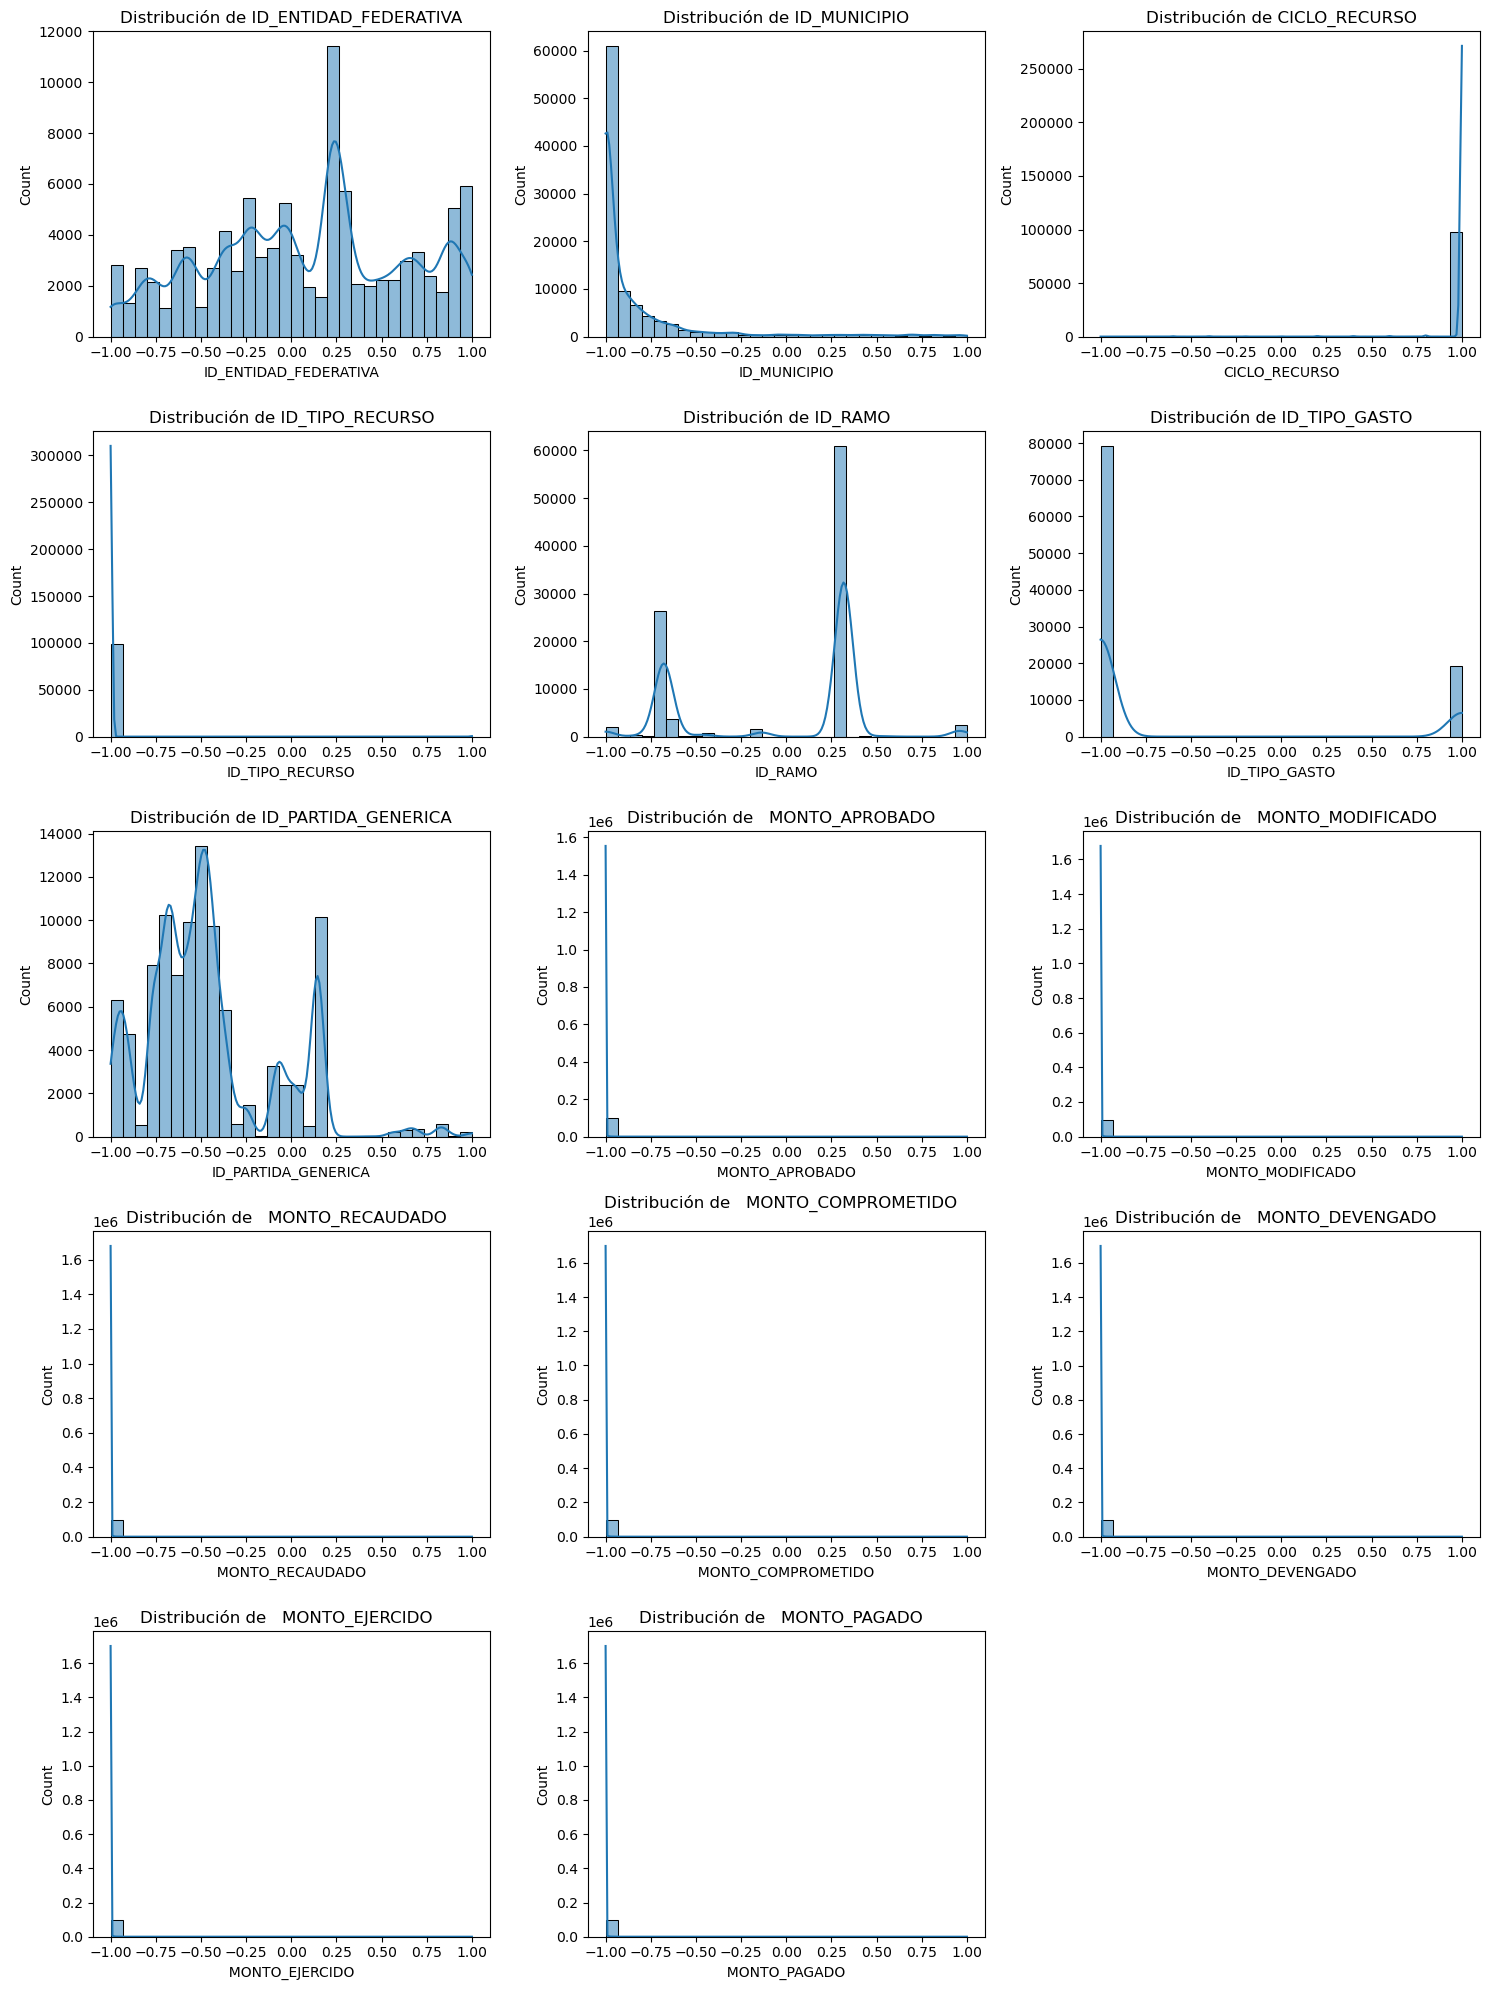

¿Necesitamos aplicar alguna transformación no lineal?


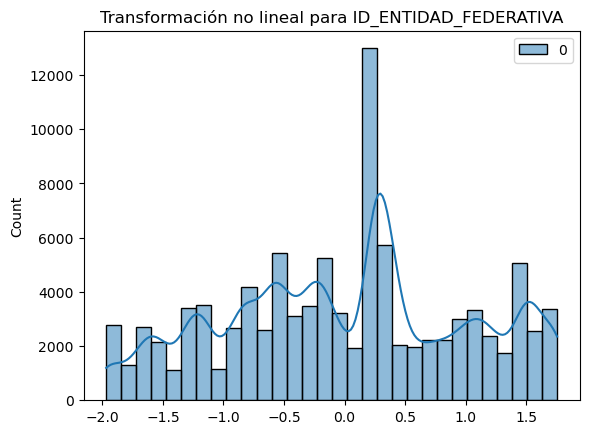

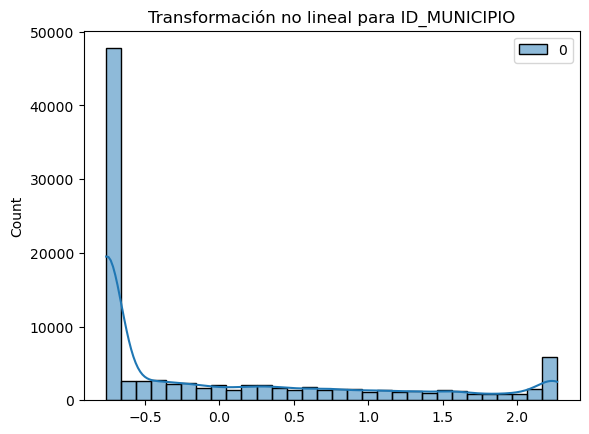

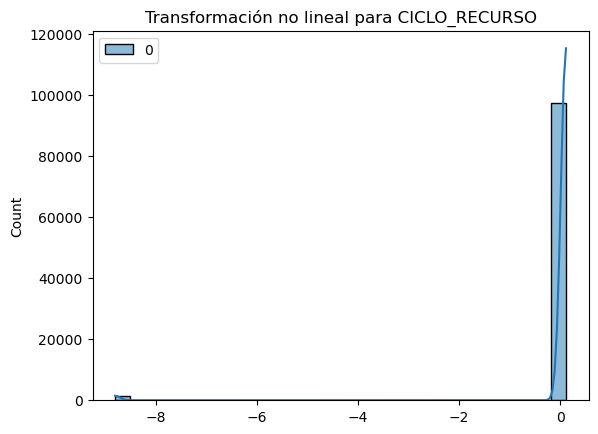

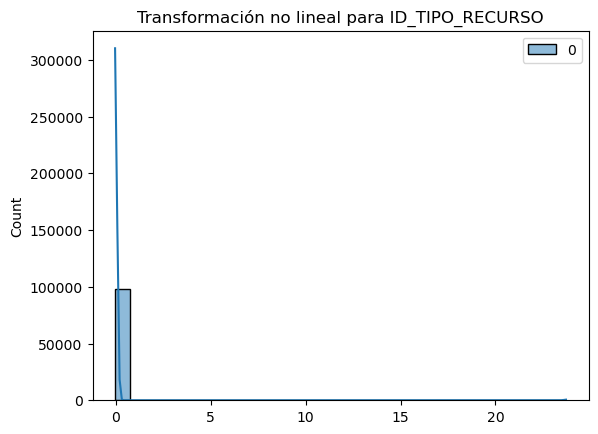

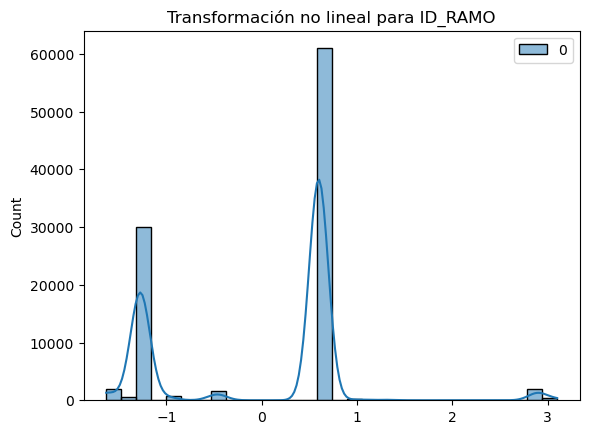

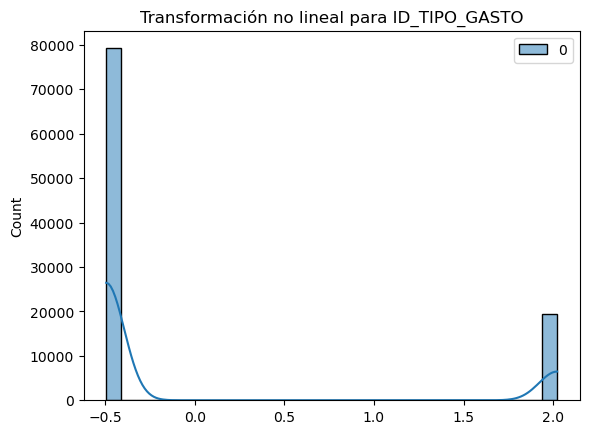

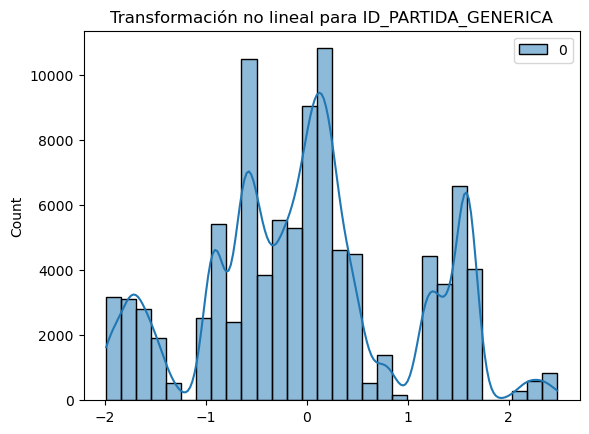

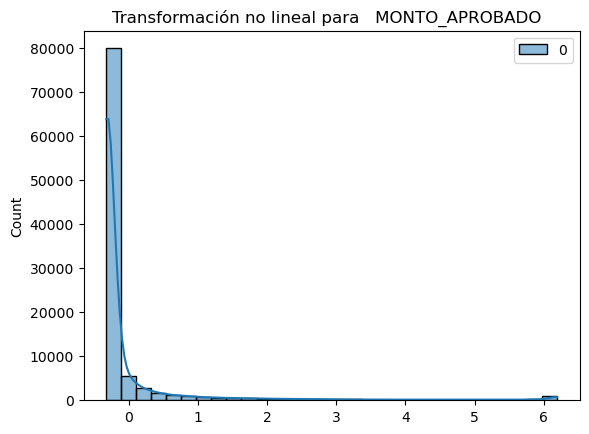

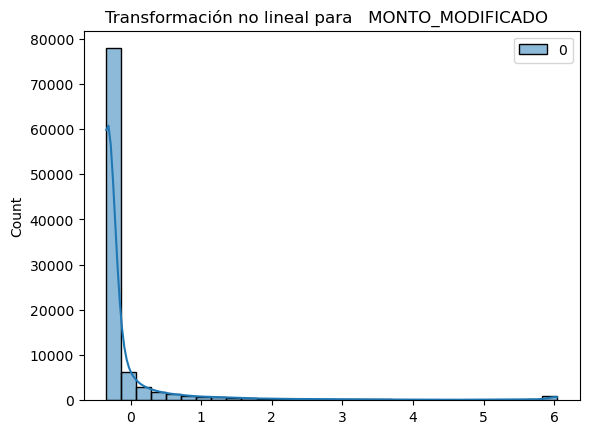

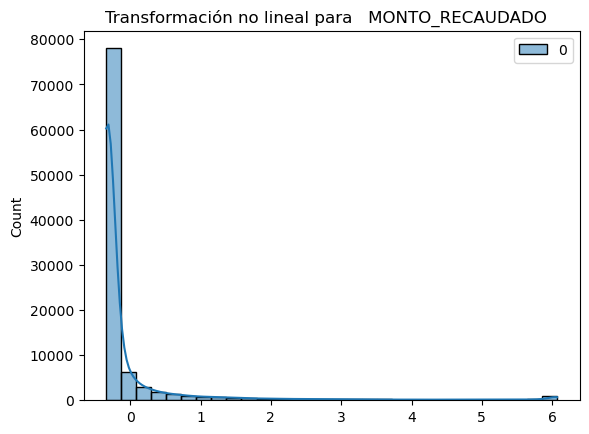

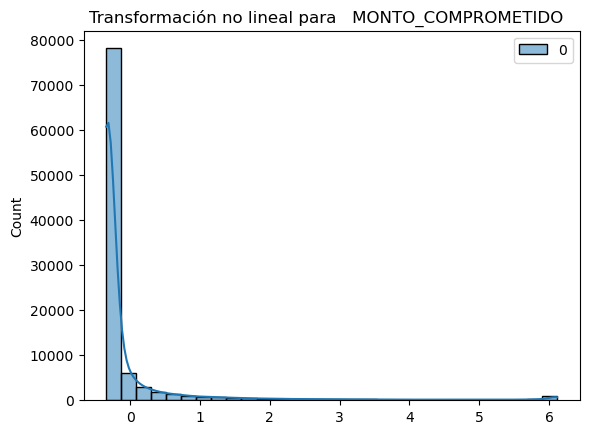

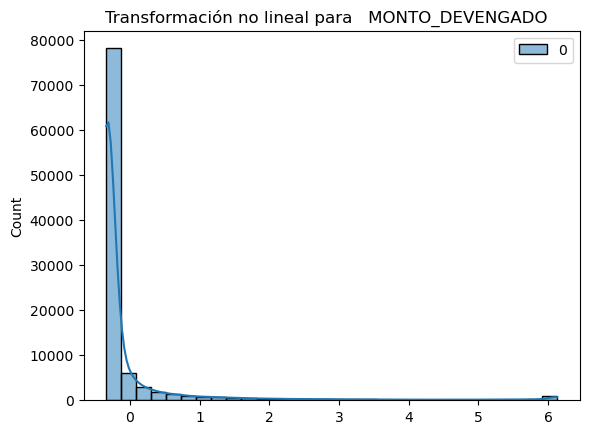

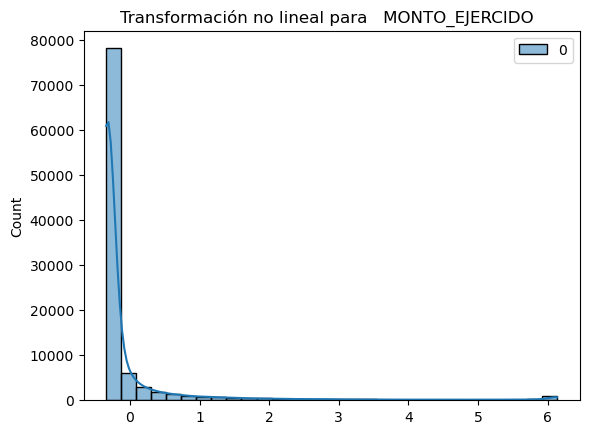

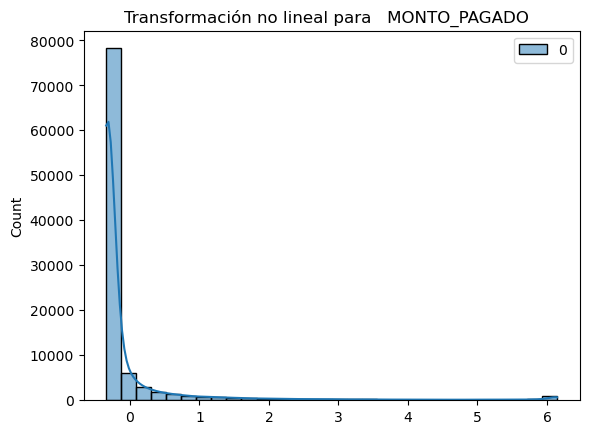

In [23]:
distribuciones_sesgadas(df_normalizado)

¿Necesitamos aplicar alguna transformación no lineal?

    Como podemos observar si se requiere transformar no lineal en algunas dist sesgadas una propuesta para ello es usar Power Transformer como se explica a continuacion

# Power Transformer

## ¿Qué es el Power Transformer?

El **Power Transformer** es una técnica de preprocesamiento utilizada en el ámbito del aprendizaje automático y la estadística para transformar variables que no siguen una distribución normal (también conocidas como distribuciones sesgadas) en variables que se asemejan más a una distribución normal. Este método es parte del módulo `sklearn.preprocessing` de Scikit-learn.

El Power Transformer aplica una transformación que busca estabilizar la varianza y hacer que los datos sean más gaussianos (distribución normal) a través de un conjunto de transformaciones de potencias.

## ¿Cómo funciona el Power Transformer?

El Power Transformer utiliza diferentes transformaciones según el valor de la variable:

- Para valores positivos, utiliza la **transformación de Box-Cox**.
- Para valores negativos y cero, utiliza la **transformación de Yeo-Johnson**.

### Proceso de Transformación

1. **Ajustar el Transformer**: Se ajusta el transformer a los datos de entrada para calcular los parámetros necesarios.
2. **Transformar los Datos**: Se aplican las transformaciones a los datos originales basándose en los parámetros calculados durante el ajuste.


In [24]:
def identificar_tendencias_temporales(df):
    if 'date' in df.columns:
        print("¿Se identifican tendencias temporales?")
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.resample('M').mean().plot()
        plt.title("Tendencias temporales de las variables")
        plt.show()
    else:
        print("No hay dimensión temporal en el conjunto de datos.")

In [25]:
identificar_tendencias_temporales(df_normalizado)

No hay dimensión temporal en el conjunto de datos.


No hay tendencias temporales debido que es en su mayoria del año 2023 sin alguna columna o categoria del tipo fecha

In [26]:
def correlacion_entre_variables(df):
    print("¿Hay correlación entre las variables dependientes e independientes?")
    
    # Calcular la matriz de correlación solo para columnas numéricas
    correlation_matrix = df.corr(numeric_only=True)  
    
    # Crear el mapa de calor
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title("Matriz de correlación")
    plt.show()

¿Hay correlación entre las variables dependientes e independientes?


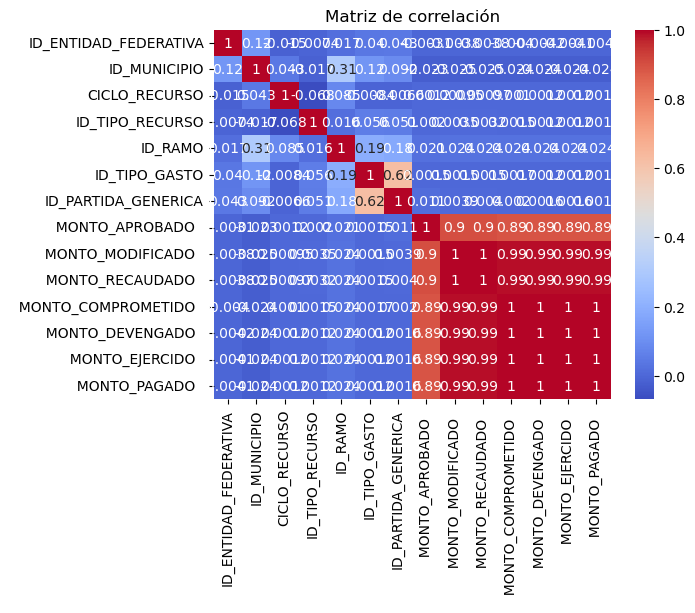

In [27]:
correlacion_entre_variables(df_normalizado)

Como podemos observar los montos son los mejores correlacionados

In [37]:
def recortar_categoria(categoria):
    # Limitar la longitud a 20 caracteres
    return categoria[:10] if len(categoria) > 10 else categoria

def distribucion_por_categorias(df):
    print("¿Cómo se distribuyen los datos en función de diferentes categorías?")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        # Aplicar la función de recorte a las categorías
        df[col] = df[col].apply(recortar_categoria)
        
        sns.countplot(x=col, data=df)
        plt.title(f'Distribución de la categoría {col}')
        plt.xticks(rotation=90)  # Rotar los nombres de las categorías verticalmente
        plt.show()

¿Cómo se distribuyen los datos en función de diferentes categorías?


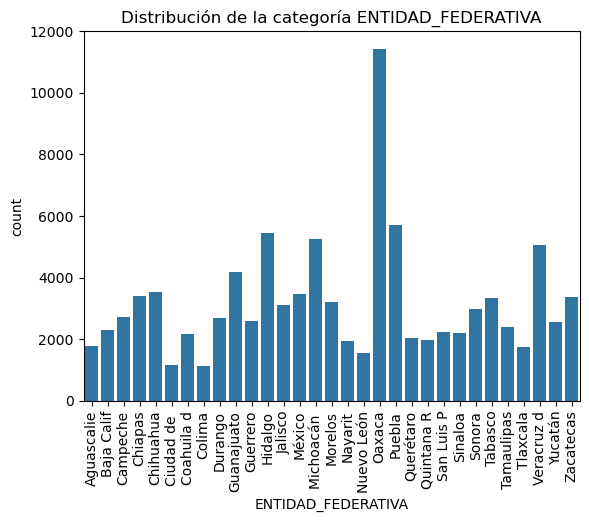

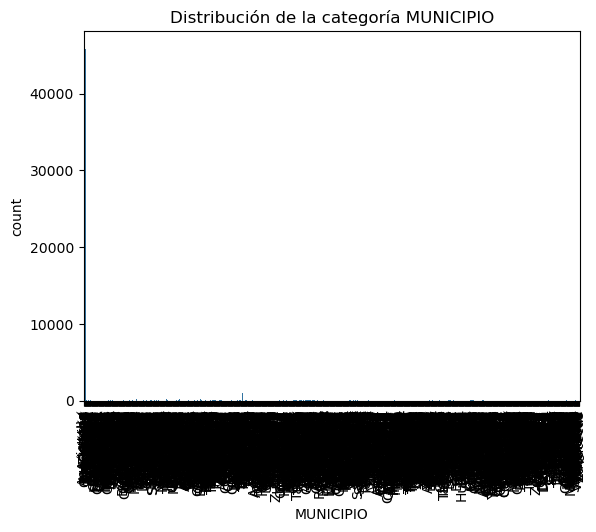

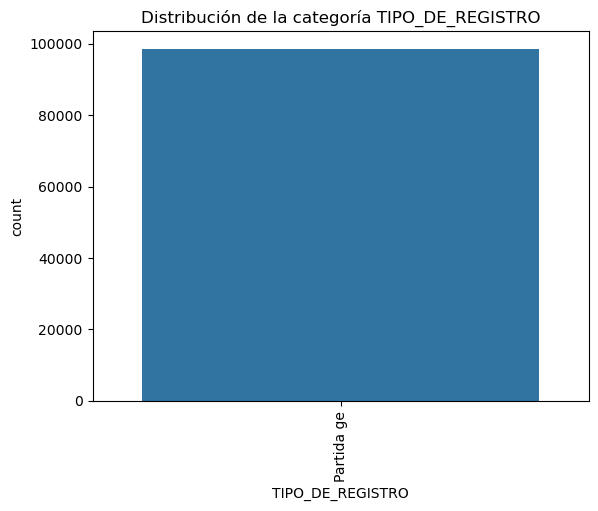

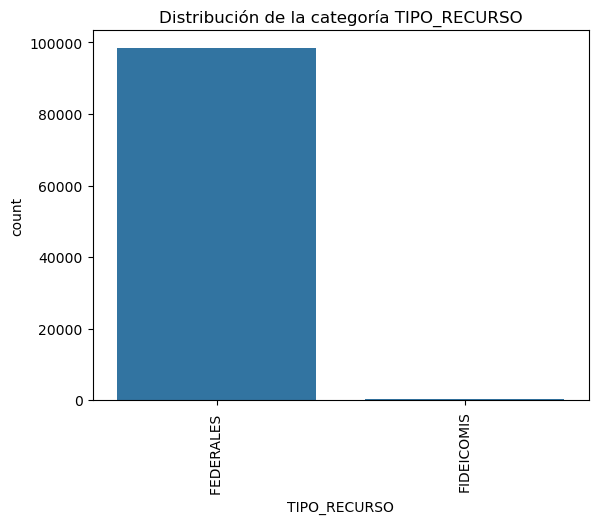

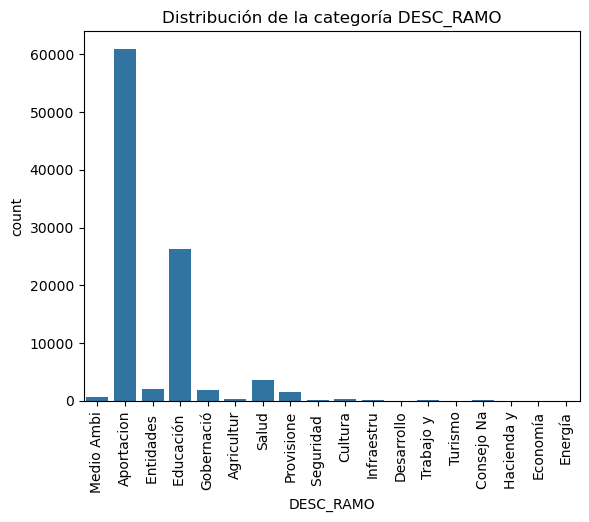

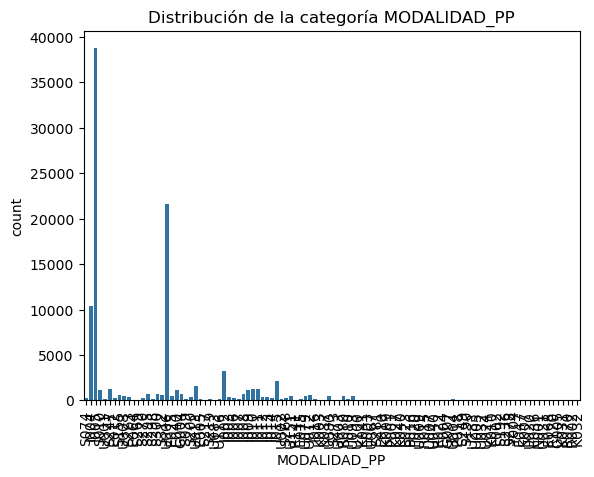

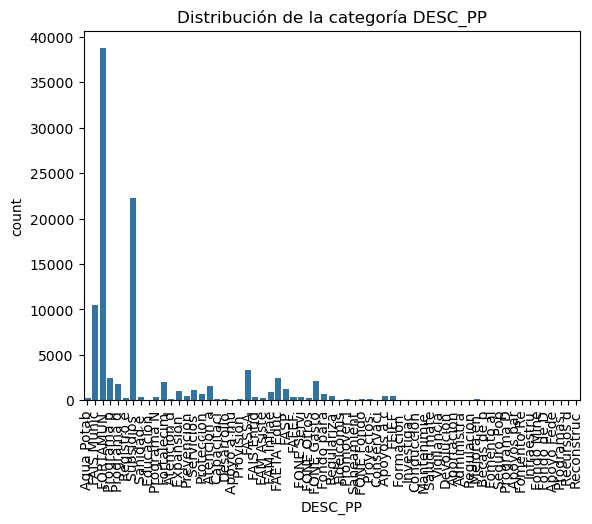

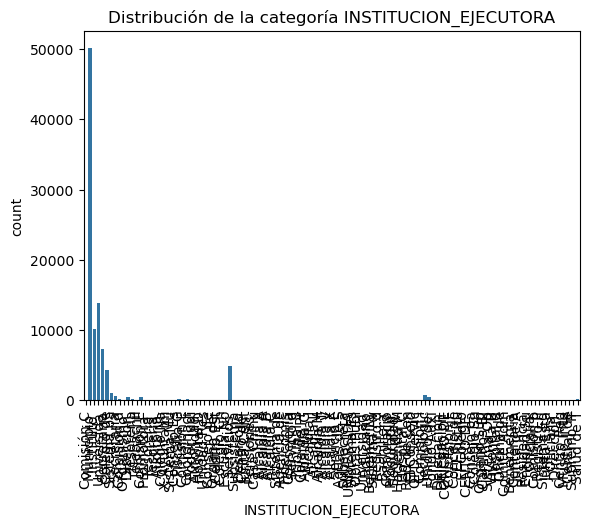

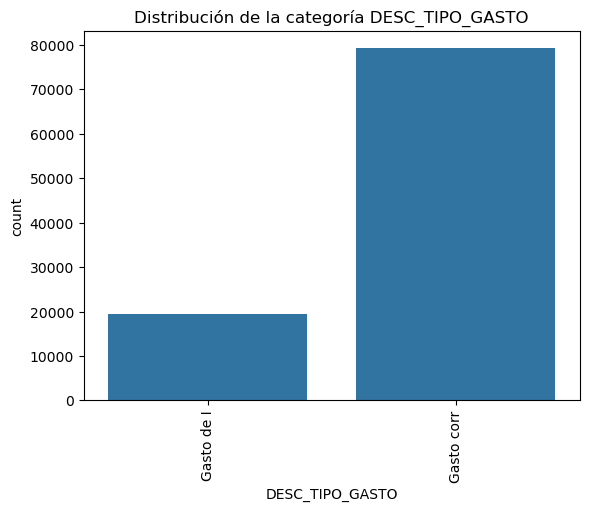

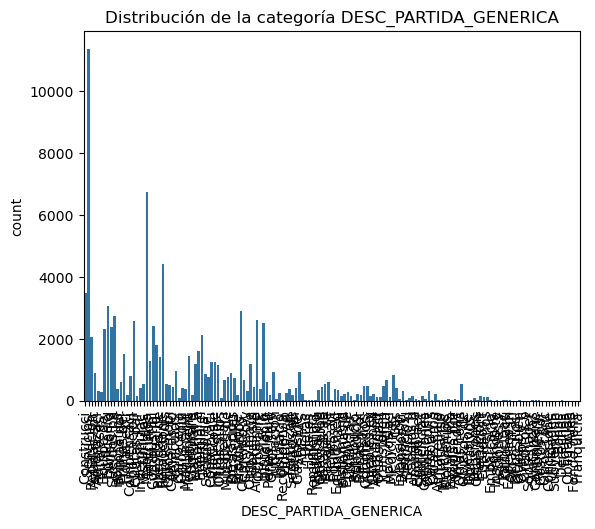

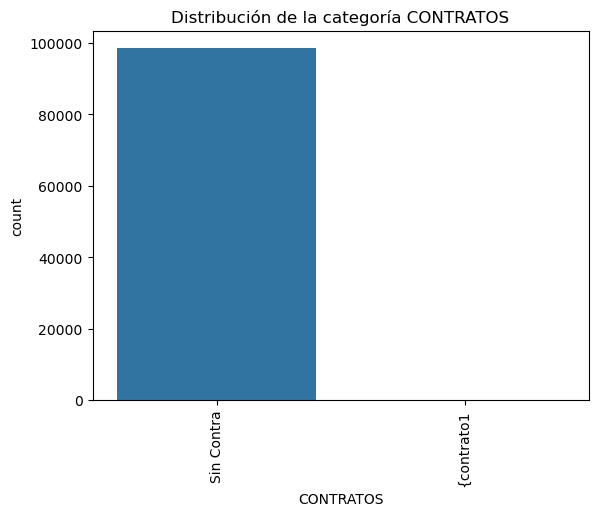

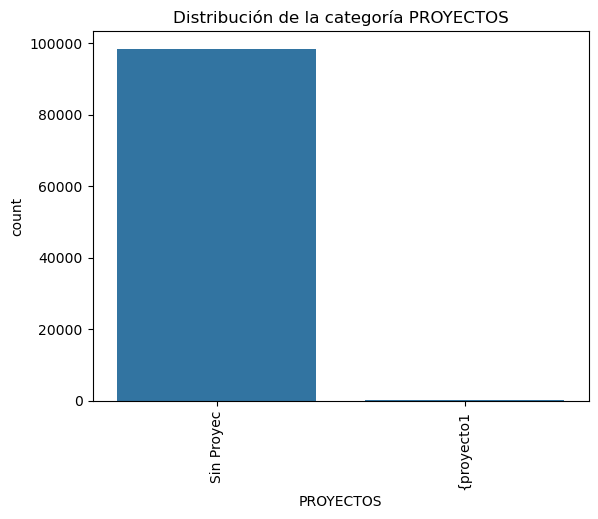

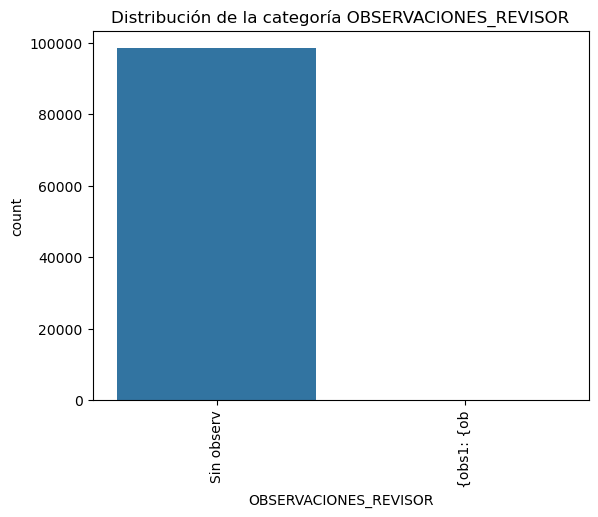

In [38]:
distribucion_por_categorias(df_normalizado)

Como podemos ver las categorias tienen diferentes distribuciones como se observa en su cardinalidad antes mencionada

In [53]:
# Ignorar RuntimeWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
def patrones_agrupaciones(df):
    print("¿Existen patrones o agrupaciones (clusters) en los datos con características similares?")
    
    # Seleccionar solo columnas numéricas
    num_cols = df.select_dtypes(include=[np.number])
    
    # Tomar solo las últimas 7 columnas numéricas
    if len(num_cols.columns) < 7:
        print("El DataFrame tiene menos de 7 columnas numéricas. Se utilizarán todas las disponibles.")
        selected_cols = num_cols.copy()  # Hacer una copia explícita
    else:
        selected_cols = num_cols.iloc[:, -7:].copy()  # Hacer una copia explícita

    # Aplicar K-means
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(selected_cols)

    # Agregar los clusters al DataFrame seleccionado
    selected_cols['Cluster'] = clusters

    # Graficar las agrupaciones usando pairplot
    sns.pairplot(selected_cols, hue='Cluster', palette='viridis')
    plt.suptitle("Visualización de Clusters en las Últimas 7 Columnas", y=1.02)  # Ajustar el título
    plt.show()

¿Existen patrones o agrupaciones (clusters) en los datos con características similares?


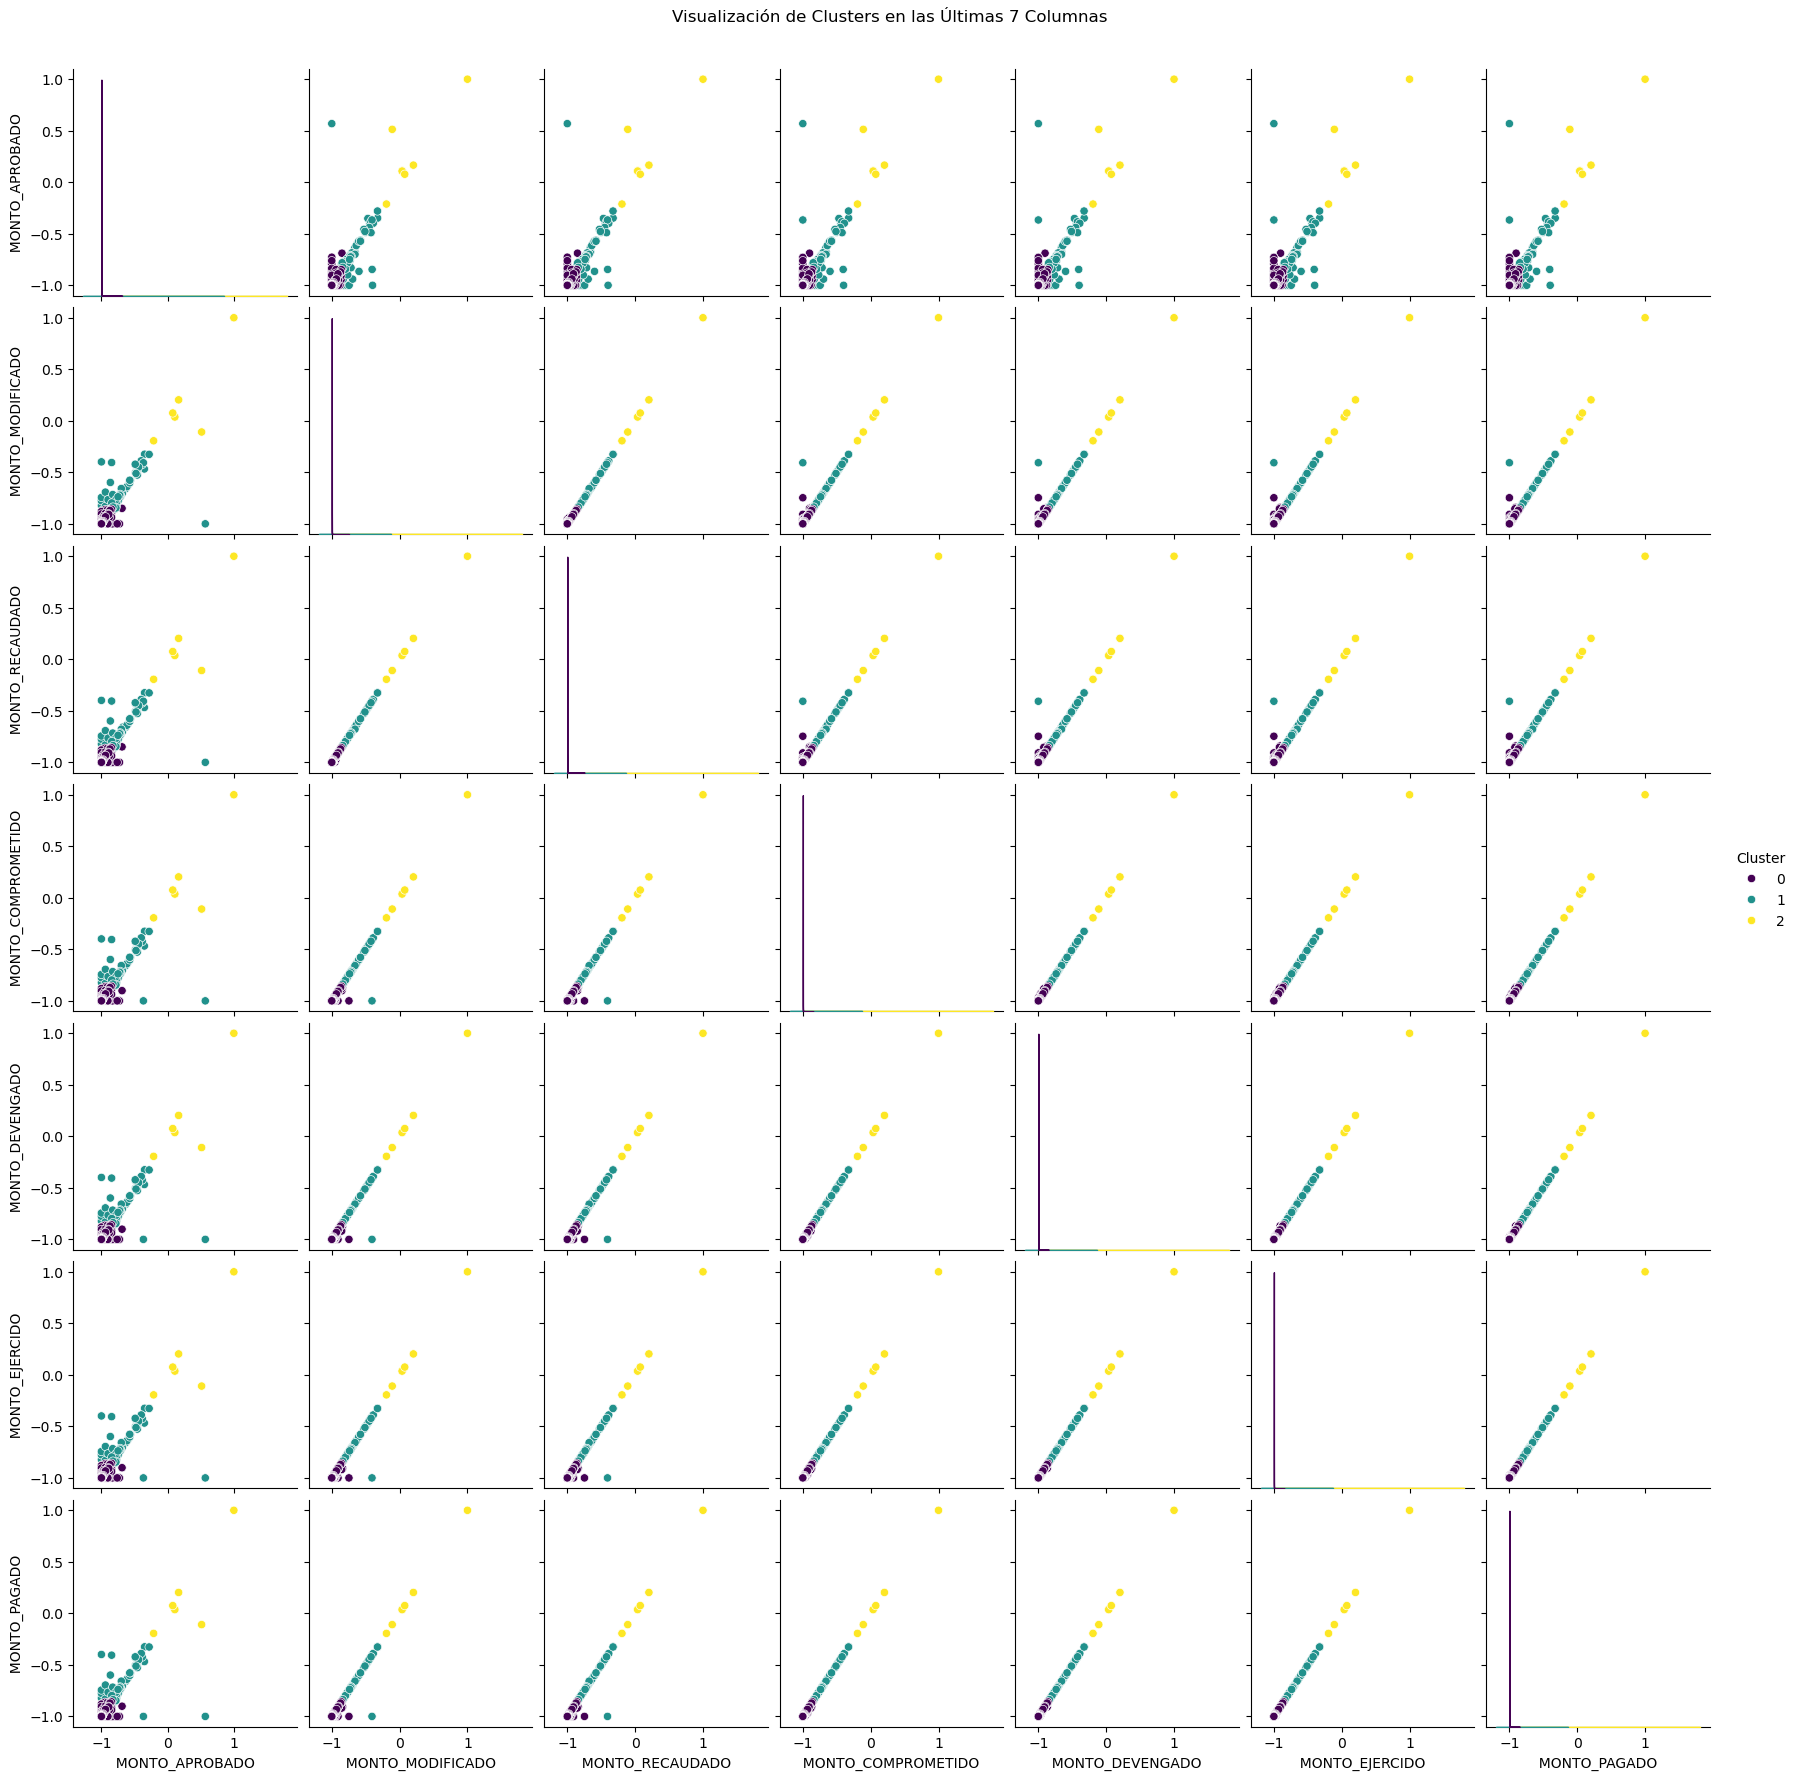

In [55]:
patrones_agrupaciones(df_normalizado)

En estos patrones de agrupacion vemos que el monto aprobado tiene mejor correlacion con otras variables por lo que analizar esta variablo benifiaria mejor nuestro modelo de conformacion de registros contables

In [78]:
variable_target = '  MONTO_PAGADO  '

¿Hay desequilibrio en las clases?

Si hay desiquilibrio de clases debido a que durante este analisis podemos observar que las categorias que tienen mas correlacion son los montos que son los numeros, mientras los Id u otros categoricos que es el texto no lo tienen, esto es normal por lo que quitar los categoricos que no nos interesan y dejar los valores numericos y algunas categorias como Entidad_Federativo, recurso y tipo de gasto  nos ayudaria a equilibrar las clases para no tener subreaprendizaje o lo contrario durante el entrenamiento del modelos

In [87]:
def analizar_desequilibrio_clases(df, variable_target):
    """
    Analiza el desequilibrio en las clases de la variable objetivo.

    Parameters:
    df (pd.DataFrame): El DataFrame que contiene la variable objetivo.
    variable_target (str): El nombre de la columna que representa la variable objetivo.

    Returns:
    dict: Un diccionario con la distribución de clases y un indicador de desequilibrio.
    """
    # Calcular la distribución de clases
    distribucion_clases = df[variable_target].value_counts(normalize=True) * 100

    # Identificar si hay desequilibrio
    desequilibrio = any(distribucion_clases < 20)  # Se puede ajustar el umbral

    # Mostrar la distribución de clases
    print("Distribución de Clases:")
    print(distribucion_clases)
    print(f"\n¿Hay desequilibrio en las clases? {'Sí' if desequilibrio else 'No'}\n")

    # Graficar la distribución de clases
    plt.figure(figsize=(8, 5))
    sns.barplot(x=distribucion_clases.index, y=distribucion_clases.values)
    plt.title(f'Distribución de Clases: {variable_target}')
    plt.xlabel(variable_target)
    plt.ylabel('Porcentaje (%)')
    plt.xticks(rotation=45)
    plt.show()

    return {
        'Distribución de Clases': distribucion_clases,
        'Desequilibrio': desequilibrio
    }

Distribución de Clases:
20000.00      0.144460
50000.00      0.139685
2000.00       0.133715
30000.00      0.131328
10000.00      0.124164
                ...   
124326.83     0.001194
343244.00     0.001194
3030835.45    0.001194
448090.04     0.001194
1055339.00    0.001194
Name:   MONTO_PAGADO  , Length: 73982, dtype: float64

¿Hay desequilibrio en las clases? Sí



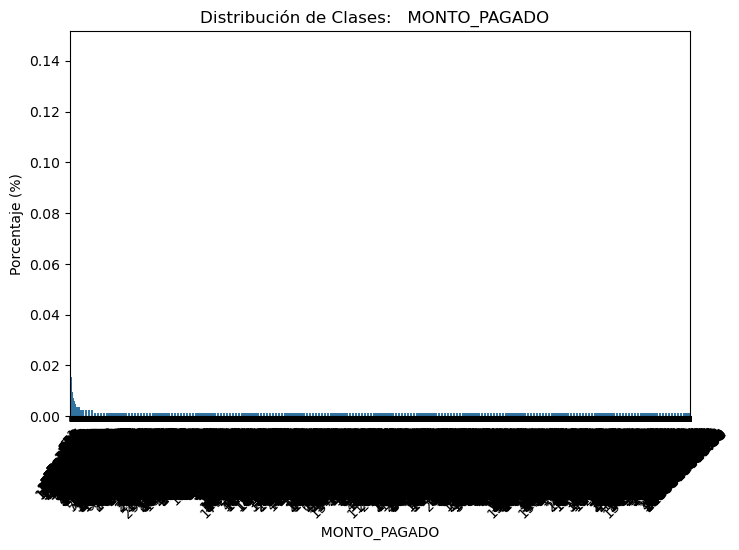

{'Distribución de Clases': 20000.00      0.144460
 50000.00      0.139685
 2000.00       0.133715
 30000.00      0.131328
 10000.00      0.124164
                 ...   
 124326.83     0.001194
 343244.00     0.001194
 3030835.45    0.001194
 448090.04     0.001194
 1055339.00    0.001194
 Name:   MONTO_PAGADO  , Length: 73982, dtype: float64,
 'Desequilibrio': True}

In [88]:
analizar_desequilibrio_clases(df, variable_target)

### Conclusiones sobre la Importancia del Preprocesamiento de Datos en EDA

El preprocesamiento de datos es una etapa esencial en el análisis exploratorio de datos (EDA) y en el desarrollo de modelos de machine learning (ML), NLP, DeepLearning. Su correcta implementación no solo optimiza el rendimiento de los modelos, también garantiza la calidad y las interferencias que se derivan del conjunto de datos como son seguir los pasos de:

1. **Identificación y Manejo de Valores Faltantes:**
   La detección de valores faltantes es crucial para evitar sesgos y errores en el análisis. El manejo adecuado de estos datos ausentes, ya sea mediante imputación o eliminación, asegura que el conjunto de datos refleje con precisión la realidad. En este caso de uso podemos obervar que tenia varios datos faltantes inclusive en todo una columna lo que podemos removerla por su poco valor.

2. **Comprensión de Estadísticas Resumidas:**
   Las estadísticas resumidas nos proporcionan una visión general de las variables, permitiendo identificar rápidamente características importantes y decidir si es necesario aplicar transformaciones. Una comprensión clara de estas estadísticas ayuda a establecer expectativas sobre el comportamiento de los datos, por ejmplo indentificar el tipo de datos de las columnas, en donde esta la media, identificar la dispersion de los datos.

3. **Detección de Valores Atípicos:**
   La identificación y gestión de valores atípicos son vitales, ya que estos pueden influir de manera desproporcionada en el resultado del modelo. A través del análisis de EDA, los analistas pueden decidir si estos valores deben ser eliminados, corregidos o mantenidos, dependiendo de su relevancia y del contexto del análisis, en nuestro caso los valores atipicos podemos eliminarlos ya que solo se presentan en las columnas del tipo int o float, recordemos que estos valores son los mas alejados de nuestra media.

4. **Cardinalidad de Variables Categóricas:**
   Evaluar la cardinalidad de las variables categóricas es importante para determinar el enfoque de codificación adecuado. Una alta cardinalidad puede complicar el modelo, en este caso de uso un analisis con PCA podria ser aplicado al tener demasiadas categorias con cardinalidades altas asi tomar la decision de reducir la dimension.

5. **Detección de Sesgos en Distribuciones:**
   Las distribuciones sesgadas pueden afectar el rendimiento de los modelos, especialmente aquellos que asumen normalidad. Identificar y corregir estas distribuciones durante el EDA por ello aplicamos transformacione no lineales adecuadas, mejorando así la eficacia del modelo y su capacidad para hacer predicciones precisas como se observo en la graficas.

6. **Análisis de Tendencias Temporales:**
   En conjuntos de datos que incluyen una dimensión temporal, el reconocimiento de tendencias es crucial. Este análisis ayuda a identificar patrones que pueden ser fundamentales para la modelización, en este caso existen el cliclo que es en 2023 y los ciclos del recurso que varia de año por lo tanto como se persigue el registro de pago no es de interes.

7. **Correlación entre Variables:**
   Comprender las correlaciones entre variables es esencial para la selección de características y para evitar redundancias. Un análisis de correlación nos ayudo a identificar relaciones que pueden ser relevantes para la variable objetivo que es el monto de pago donde algunos montos pueden ser redundantes y algunas categorias sin uso relevante.

8. **Distribución por Categorías:**
   El análisis de la distribución de los datos según categorías permite entender el comportamiento de diferentes grupos en el conjunto de datos. Este conocimiento nos ayuda a crear modelos que consideren las diferencias entre categorías como en este caso al tener diferentes cardinalidades podemos asumir que las distribuciones no son uniforme para asegurar que las predicciones sean precisas y relevantes.

9. **Identificación de Patrones y Agrupaciones:**
   La detección de patrones y agrupaciones en los datos puede guiar la creación de nuevos atributos que mejoren la precisión del modelo. La exploración de agrupaciones nos permite identificar características subyacentes en los datos en la categoria de monto aprobado al tener mejor correlacion con las otras variables ademas de pocos valores atipicos.

10. **Manejo del Desequilibrio en Clases:**
    Un desbalance en la variable objetivo puede comprometer la efectividad del modelo. Identificamos este desbalance y nos ayuda para aplicar técnicas de preprocesamiento adecuadas como no llenar los NaN con ceros, reducir la dimensionalidad, identificar nuestras categorias como lo describimos en los anteriores puntos, esto debido al sobremuestreo o el submuestreo.

### Resumen Final

El preprocesamiento de datos es una etapa fundamental que complementa el EDA al proporcionar una base sólida para la modelar. Un análisis exploratorio riguroso, combinado con prácticas de preprocesamiento efectivas, maximiza la calidad de los datos. Esta combinancion nos ayuda a interpretar mejor los resultados con cada tecnica que implementamos. Implementar correctamente estas prácticas de EDA y preprocesamiento es esencial para cualquier proyecto de ciencia de datos.

